Disclaimer:
I was not able to import the data_cleaning collab file as a module so for the moment this is a copy of data_cleaning with some addition at the end to run a quick baseline with scikit learn 



In [0]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

In [0]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline,linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import keras
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [0]:
!wget https://propaganda.qcri.org/semeval2020-task11/data/datasets-v2.tgz
!tar xzvf datasets-v2.tgz

--2020-03-19 17:30:31--  https://propaganda.qcri.org/semeval2020-task11/data/datasets-v2.tgz
Resolving propaganda.qcri.org (propaganda.qcri.org)... 80.76.166.234
Connecting to propaganda.qcri.org (propaganda.qcri.org)|80.76.166.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1142202 (1.1M) [application/x-gzip]
Saving to: ‘datasets-v2.tgz’

datasets-v2.tgz     100%[===================>]   1.09M   575KB/s    in 1.9s    

2020-03-19 17:30:40 (575 KB/s) - ‘datasets-v2.tgz’ saved [1142202/1142202]

datasets/
datasets/README.md
datasets/train-labels-task1-span-identification/
datasets/train-labels-task1-span-identification/article728972961.task1-SI.labels
datasets/train-labels-task1-span-identification/article111111136.task1-SI.labels
datasets/train-labels-task1-span-identification/article790667730.task1-SI.labels
datasets/train-labels-task1-span-identification/article770156851.task1-SI.labels
datasets/train-labels-task1-span-identification/article786250729.task

In [0]:
train_articles = os.listdir("datasets/train-articles")
train_labels_tags_span = os.listdir("datasets/train-labels-task1-span-identification")
train_tags_technique = os.listdir("datasets/train-labels-task2-technique-classification")
train_articles.sort()
train_labels_tags_span.sort()

Step 1: Gather tables from Task 1 folder and place them into a dict type where the article number is the key

In [0]:
# Dictionary containing news articlc
propTagsSpan = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets/train-labels-task1-span-identification/"+ articleNoExt + ".task1-SI.labels"
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsSpan[articleNoExt] = tags
    r.close()
    
print(propTagsSpan[train_articles[0]])
    

['111111111 265 323 ', '111111111 1795 1935 ', '111111111 149 157 ', '111111111 1069 1091 ', '111111111 1334 1462 ', '111111111 1577 1616 ', '111111111 2023 2086 ']


Step 2: Do the same for task 2

In [0]:
propagandaTagTechnique = os.listdir("datasets/train-labels-task2-technique-classification")
propagandaTagTechnique.sort()
propTagsTechnique = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets/train-labels-task2-technique-classification/"+ articleNoExt + ".task2-TC.labels"
    
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace(articleNo, " ")
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsTechnique [articleNoExt] = tags
    r.close()
    
print(propTagsTechnique[train_articles[0]])
    

['  Appeal_to_Authority 265 323 ', '  Appeal_to_Authority 1795 1935 ', '  Doubt 149 157 ', '  Repetition 1069 1091 ', '  Appeal_to_fear-prejudice 1334 1462 ', '  Appeal_to_fear-prejudice 1577 1616 ', '  Appeal_to_fear-prejudice 1856 1910 ', '  Appeal_to_fear-prejudice 2023 2086 ']


Step 3: Put sentences that have annotation "propoganda" as a list

In [0]:
propoganda_sent_span = []

for article in train_articles:
    article_path = "datasets/train-articles/" + article + ".txt"
    tags = propTagsSpan[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            
            propoganda_sent_span.append(tag_line)
    r.close()

print(propoganda_sent_span[0])

The next transmission could be more pronounced or stronger


Step 4: Create a dictionary with the keys being the propoganda sentences and the values being their associated propoganda type. 

In [0]:
propoganda_techniques = {}
propoganda_techniques["Sentence"] = []
propoganda_techniques["Technique"] = []

for article in train_articles:
    article_path = "datasets/train-articles/" + article + ".txt"
    tags = propTagsTechnique[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            propoganda_techniques["Technique"].append(tag[0])
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            propoganda_techniques["Sentence"].append(tag_line)     
    r.close()  

Step 5: Using the list of propoganda sentences to create a list of non propoganda sentences

Step 6: Convert dictionary into DataFrame


In [0]:
df = pd.DataFrame.from_dict(propoganda_techniques)
df

,Sentence,Technique
0,The next transmission could be more pronounced...,Appeal_to_Authority
1,when (the plague) comes again it starts from m...,Appeal_to_Authority
2,appeared,Doubt
3,"a very, very different",Repetition
4,He also pointed to the presence of the pneumon...,Appeal_to_fear-prejudice
...,...,...
6124,the Left killed comedy,Slogans
6125,"no one looks in the mirror and thinks, ‘this b...","Exaggeration,Minimisation"
6126,Columbia snowflakes,"Name_Calling,Labeling"
6127,"Comrades, these jokes you have been listening ...","Exaggeration,Minimisation"


Step 7: Plot data per class


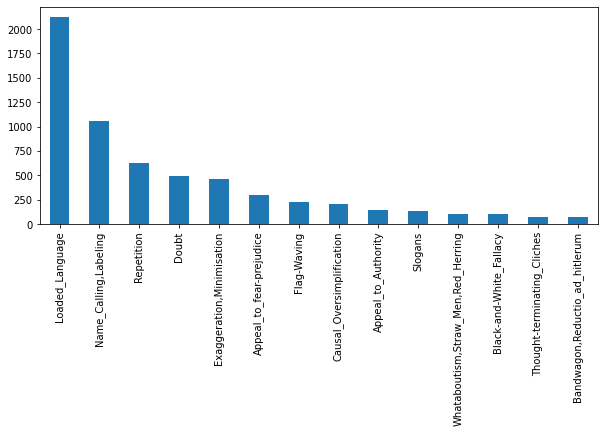

In [0]:
propoganda_techniques_tags = ['Appeal_to_Authority','Name_Calling,Labeling','Slogans', 'Loaded_Language','Appeal_to_fear-prejudice','Repetition','Doubt','Exaggeration,Minimisation','Flag-Waving','Causal_Oversimplification','Whataboutism,Straw_Men,Red_Herring','Black-and-White_Fallacy','Thought-terminating_Cliches','Bandwagon,Reductio_ad_hitlerum']
plt.figure(figsize=(10,4))
df.Technique.value_counts().plot(kind='bar');

Step 8: inspect language by checking sentence - tag pair 

In [0]:
def print_plot(index):
    example = df[df.index == index][['Sentence', 'Technique']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print_plot(20)

pinned blame steinles death illegal immigration insufficiently aggressive deportation policies
Tag: Causal_Oversimplification


In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Step 10: Prepocessing - even if the data is very clean

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text - not sure if we want to do this
    return text
    
df['Sentence'] = df['Sentence'].apply(clean_text)
print_plot(20)

pinned blame steinles death illegal immigration insufficiently aggressive deportation policies
Tag: Causal_Oversimplification


step 11: Count number of token post preprocessing

In [0]:
df['Sentence'].apply(lambda x: len(x.split(' '))).sum()

28181

Step 12: split the training data into train and test sets

In [0]:
X = df.Sentence
y = df.Technique
#random_state sets a seed, the train-test splits are always deterministic. If the seed is not set, train-test splits are different each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 

Step 13: create a ML pipeline where we stack the Sentence vectorisation (TFIDF, CountVec) and the model - This structure will repaet later but we'll change the models

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Step 14: Check predictions metrics

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=propoganda_techniques_tags))
print(f1_score(y_test, y_pred, average='weighted'))

accuracy 0.46084828711256115
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        42
             Name_Calling,Labeling       0.00      0.00      0.00        48
                           Slogans       0.00      0.00      0.00        22
                   Loaded_Language       0.00      0.00      0.00        15
          Appeal_to_fear-prejudice       0.00      0.00      0.00        43
                        Repetition       0.56      0.10      0.17        97
                             Doubt       0.50      0.01      0.02        94
         Exaggeration,Minimisation       0.40      0.05      0.09        40
                       Flag-Waving       0.43      0.95      0.59       444
         Causal_Oversimplification       0.55      0.42      0.48       198
Whataboutism,Straw_Men,Red_Herring       0.75      0.39      0.51       122
           Black-and-White_Fallacy       0.00      0.00   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Step 15: Baseline with Logistic Regression


In [0]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='lbfgs', multi_class='auto')),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=propoganda_techniques_tags))
print(f1_score(y_test, y_pred, average='weighted'))

accuracy 0.4934747145187602
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        42
             Name_Calling,Labeling       0.38      0.06      0.11        48
                           Slogans       0.00      0.00      0.00        22
                   Loaded_Language       0.00      0.00      0.00        15
          Appeal_to_fear-prejudice       1.00      0.02      0.05        43
                        Repetition       0.44      0.25      0.32        97
                             Doubt       0.35      0.16      0.22        94
         Exaggeration,Minimisation       0.43      0.23      0.30        40
                       Flag-Waving       0.48      0.92      0.63       444
         Causal_Oversimplification       0.54      0.45      0.49       198
Whataboutism,Straw_Men,Red_Herring       0.75      0.43      0.54       122
           Black-and-White_Fallacy       0.75      0.13    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline with Linear classifiers (SVM, logistic regression, a.o.) with SGD training

In [0]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=propoganda_techniques_tags))
print(f1_score(y_test, y_pred, average='macro'))

accuracy 0.5415986949429038
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.33      0.07      0.12        42
             Name_Calling,Labeling       0.31      0.19      0.23        48
                           Slogans       0.57      0.18      0.28        22
                   Loaded_Language       0.33      0.20      0.25        15
          Appeal_to_fear-prejudice       0.61      0.26      0.36        43
                        Repetition       0.43      0.41      0.42        97
                             Doubt       0.40      0.32      0.36        94
         Exaggeration,Minimisation       0.44      0.45      0.44        40
                       Flag-Waving       0.59      0.85      0.70       444
         Causal_Oversimplification       0.53      0.46      0.49       198
Whataboutism,Straw_Men,Red_Herring       0.62      0.53      0.58       122
           Black-and-White_Fallacy       0.35      0.26    